# Facebook Ego Network Analysis

## 1. Import Libraries

In this section, we import all Python libraries required for analyzing the Facebook Ego Network dataset.

We use:

- **NetworkX** for graph handling and structural metrics  
- **Pandas** for data manipulation  
- **Matplotlib** and **Seaborn** for visualizations  
- **NumPy** for numerical operations  
- **random** for approximate sampling  
- **greedy_modularity_communities** for community detection  

These tools form the foundation for exploring the structure and dynamics of the Facebook ego network.


In [14]:
import networkx as nx
from networkx.algorithms.approximation import diameter as approx_diameter
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities

## 2. Load the Facebook Ego Network Graph

We load the Facebook combined ego-network dataset as an **undirected graph**.

The dataset contains edges of the form:

```node_i node_j```

Indicating that users *i* and *j* are connected.

After loading, we display the number of nodes and edges to verify that the graph structure was successfully created.

In [16]:
# You can find the files to download in the project report of the repository
path = r"your_path/facebook_combined.txt"
G = nx.read_edgelist(
    path,
    delimiter=" ",
    create_using=nx.Graph(),
    nodetype=int
)

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph loaded: 4039 nodes, 88234 edges


## 3. Diameter and Density (Approximate)

The **diameter** of a graph is the longest shortest-path distance between any pair of nodes.  
Computing the exact diameter of a graph with millions of edges is expensive, so we use an **approximation algorithm**.

We also compute the **density**, which indicates how interconnected the network is.  
Large social networks typically have low density due to sparse connections.

In [18]:
diam_approx = approx_diameter(G)
print("Approx diameter:", diam_approx)
print("Density: ", nx.density(G))

Approx diameter: 8
Density:  0.010819963503439287


## 4. Approximate Structural Metrics

Large networks make exact computations expensive, so we approximate:

### **4.1 Approximate Average Shortest Path Length**
We randomly sample a subset of nodes and compute the mean shortest-path distances from each sampled node.

### **4.2 Approximate Average Clustering Coefficient**
We estimate the average clustering coefficient. This measures how often a node’s neighbors are also connected.

Both of these approximations are frequently used when analyzing large-scale real-world social networks.


In [20]:
def approximate_avg_shortest_path(G, sample_size=100):
    nodes = list(G.nodes())
    sample_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    total_length = 0
    count = 0
    for node in sample_nodes:
        lengths = nx.single_source_shortest_path_length(G, node)
        total_length += sum(lengths.values())
        count += len(lengths) - 1
    return total_length / count

asp_approx = approximate_avg_shortest_path(G, sample_size=1000)
print("Approximate average shortest path length:", asp_approx)

def approximate_avg_clustering(G, sample_size=1000):
    nodes = list(G.nodes())
    sample_nodes = random.sample(nodes, min(sample_size, len(nodes)))
    clustering_sum = 0
    for node in sample_nodes:
        clustering_sum += nx.clustering(G, node)
    return clustering_sum / len(sample_nodes)

clustering_approx = approximate_avg_clustering(G, sample_size=1000)
print("Approximate average clustering coefficient:", clustering_approx)

Approximate average shortest path length: 3.7015465577018327
Approximate average clustering coefficient: 0.6097293370315785


## 5. Node Centrality Measures

To understand influence and importance within the Facebook network, we compute several centrality metrics:

### **5.1 PageRank**
Measures influence of each node based on link structure.  
Useful for identifying “important” users.

### **5.2 Betweenness Centrality (approximate)**
We approximate betweenness by sampling `k` nodes (default: 100).  
This measures how often a node lies on shortest paths between others.

### **5.3 HITS Algorithm (Hubs & Authorities)**
- **Hub score:** nodes that link to many high-authority nodes  
- **Authority score:** nodes linked by many good hubs

We store all centrality scores into a pandas DataFrame for further analysis and visualization.


In [22]:
# PageRank
pagerank_scores = nx.pagerank(G, alpha=0.85)

# Betweenness Centrality
k = min(100, len(G.nodes()))
betweenness_scores = nx.betweenness_centrality(G, k=k, seed=42)

# HITS (Hub/Authority)
hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)

data = {}
for node in G.nodes():
    data[node] = {
        "pagerank": pagerank_scores[node],
        "betweenness": betweenness_scores[node],
        "hub": hubs[node],
        "authority": authorities[node]
    }

df = pd.DataFrame.from_dict(data, orient='index')

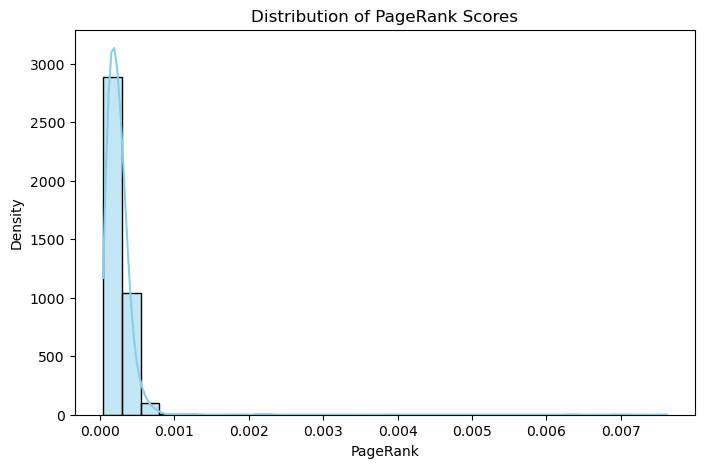

Percentage of pagerank scores below 0.001%: 99.7029%


,pagerank,betweenness,hub,authority
3437,0.007615,0.187540,4.902888e-09,4.902888e-09
107,0.006936,0.497257,1.072491e-05,1.072491e-05
1684,0.006367,0.345927,3.926877e-07,3.926877e-07
0,0.006290,0.157352,2.124473e-06,2.124473e-06
1912,0.003877,0.235988,6.117290e-03,6.117290e-03
348,0.002348,0.039888,8.539185e-07,8.539185e-07
686,0.002219,0.030284,3.784134e-13,3.784147e-13
3980,0.002170,0.032204,3.011729e-09,3.011729e-09
414,0.001800,0.042751,7.082139e-07,7.082139e-07
698,0.001317,0.092635,5.042348e-11,5.042348e-11


In [24]:
df_sorted = df.sort_values(by='pagerank', ascending=False)

plt.figure(figsize=(8,5))
sns.histplot(df['pagerank'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of PageRank Scores')
plt.xlabel('PageRank')
plt.ylabel('Density')
plt.show()

count_below = (df['pagerank'] < 0.001).sum()
total = len(df['pagerank'])
percentage = (count_below / total) * 100
print(f"Percentage of pagerank scores below 0.001%: {percentage:.4f}%")

df_sorted.head(12)

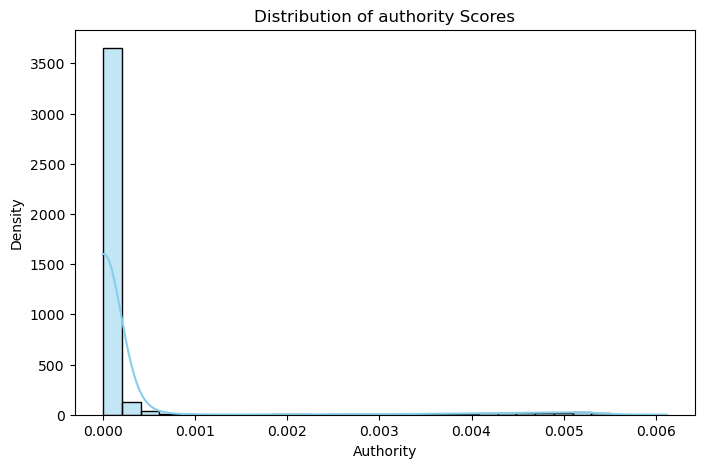

,pagerank,betweenness,hub,authority
1912,0.003877,0.235988,6.117290e-03,6.117290e-03
2266,0.000455,0.001764,5.577249e-03,5.577249e-03
2206,0.000380,0.000005,5.517567e-03,5.517567e-03
2233,0.000421,0.000039,5.461203e-03,5.461203e-03
2464,0.000364,0.000004,5.403845e-03,5.403845e-03
...,...,...,...,...
841,0.000062,0.000000,2.349494e-15,2.349451e-15
775,0.000074,0.000000,2.345886e-15,2.346050e-15
749,0.000074,0.000000,2.345886e-15,2.345988e-15
692,0.000048,0.000000,2.330514e-15,2.330795e-15


In [26]:
plt.figure(figsize=(8,5))
sns.histplot(df['authority'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of authority Scores')
plt.xlabel('Authority')
plt.ylabel('Density')
plt.show()

df_sorted = df.sort_values(by='authority', ascending=False)
df_sorted

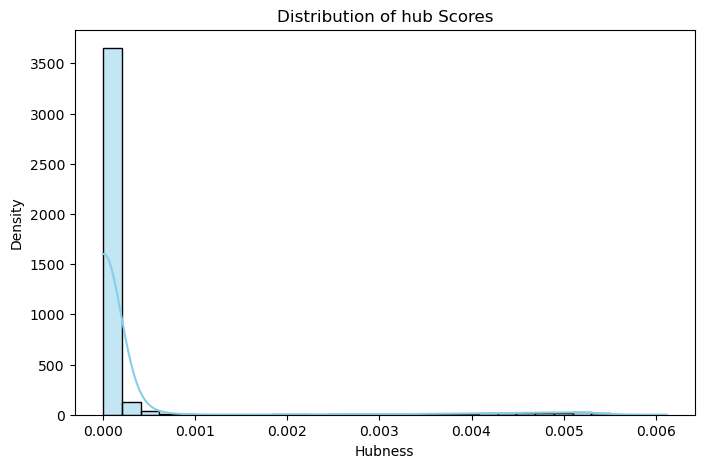

,pagerank,betweenness,hub,authority
1912,0.003877,0.235988,6.117290e-03,6.117290e-03
2266,0.000455,0.001764,5.577249e-03,5.577249e-03
2206,0.000380,0.000005,5.517567e-03,5.517567e-03
2233,0.000421,0.000039,5.461203e-03,5.461203e-03
2464,0.000364,0.000004,5.403845e-03,5.403845e-03
...,...,...,...,...
841,0.000062,0.000000,2.349494e-15,2.349451e-15
775,0.000074,0.000000,2.345886e-15,2.346050e-15
749,0.000074,0.000000,2.345886e-15,2.345988e-15
801,0.000048,0.000000,2.330514e-15,2.330583e-15


In [30]:
plt.figure(figsize=(8,5))
sns.histplot(df['hub'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of hub Scores')
plt.xlabel('Hubness')
plt.ylabel('Density')
plt.show()

df_sorted = df.sort_values(by='hub', ascending=False)
df_sorted

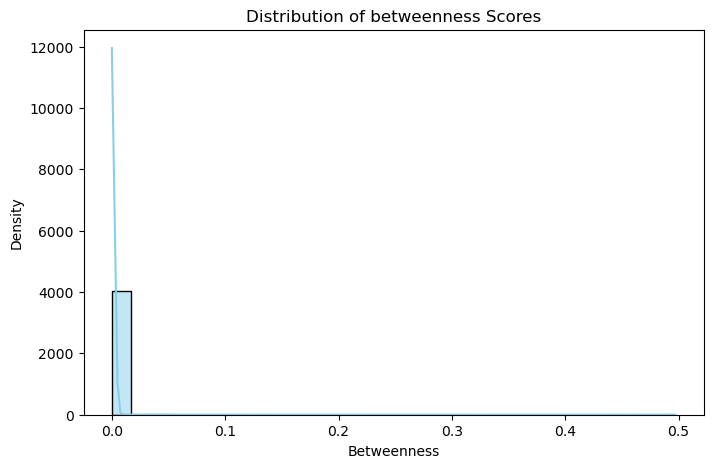

,pagerank,betweenness,hub,authority
107,0.006936,0.497257,1.072491e-05,1.072491e-05
1684,0.006367,0.345927,3.926877e-07,3.926877e-07
1912,0.003877,0.235988,6.117290e-03,6.117290e-03
3437,0.007615,0.187540,4.902888e-09,4.902888e-09
0,0.006290,0.157352,2.124473e-06,2.124473e-06
1085,0.000598,0.129863,1.100867e-07,1.100867e-07
698,0.001317,0.092635,5.042348e-11,5.042348e-11
58,0.000214,0.091888,3.776815e-05,3.776815e-05
567,0.000482,0.075903,6.188534e-07,6.188534e-07
428,0.000780,0.061605,3.831156e-05,3.831156e-05


In [32]:
plt.figure(figsize=(8,5))
sns.histplot(df['betweenness'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of betweenness Scores')
plt.xlabel('Betweenness')
plt.ylabel('Density')
plt.show()

df_sorted = df.sort_values(by='betweenness', ascending=False)
df_sorted.head(12)

## 6. Extract Ego-Network Feature Information

In this section, we work with the *per-ego* files included in the Facebook Ego Network dataset.
For each selected ego user, we load:

- **Feature names** (`.featnames`)
- **Ego’s own feature vector** (`.egofeat`)
- **Friend feature vectors** (`.feat`)
- **Ego network edges** (`.edges`)
- **Circle/cluster annotations** (`.circles`), if available

From these, we compute:

- Number of features  
- Number of friends  
- Number of edges in the ego network  
- Number of circles (communities) the ego belongs to  
- Ego’s feature vector  
- Average feature vector of their friends  

Finally, all values are merged into a single DataFrame (`final_df`) indexed by ego ID.


In [34]:
# You can find the files to download in the project report of the repository
path2 = r"your_path/facebook"

ego_ids = [0,107,348, 414, 686, 698, 3437, 3980, 1912, 1684]
ego_data = []

for ego in ego_ids:
    try:
        featnames_path = os.path.join(path2, f"{ego}.featnames")
        with open(featnames_path, "r", encoding="utf-8") as f:
            featnames = [line.strip().split(" ", 1)[1] for line in f]

        ego_feat = np.loadtxt(os.path.join(path2, f"{ego}.egofeat"))
        friend_feats = np.loadtxt(os.path.join(path2, f"{ego}.feat"))
        num_friends = friend_feats.shape[0]
        avg_friend_feat = friend_feats.mean(axis=0)

        min_len = min(len(featnames), len(avg_friend_feat))
        featnames = featnames[:min_len]
        avg_friend_feat = avg_friend_feat[:min_len]
        ego_feat = ego_feat[:min_len]

        with open(os.path.join(path2, f"{ego}.edges"), "r") as f:
            num_edges = sum(1 for _ in f)

        circles_path = os.path.join(path2, f"{ego}.circles")
        num_circles = sum(1 for _ in open(circles_path, "r")) if os.path.exists(circles_path) else 0

        ego_data.append({
            "ego_id": ego,
            "num_features": len(featnames),
            "num_friends": num_friends,
            "num_edges": num_edges,
            "num_circles": num_circles,
            "ego_feat": pd.Series(ego_feat, index=featnames),
            "avg_friend_feat": pd.Series(avg_friend_feat, index=featnames)
        })

    except FileNotFoundError:
        print(f"Missing files for ego {ego}, skipping.")

df = pd.DataFrame(ego_data)
ego_feat_df = pd.DataFrame(df["ego_feat"].tolist()).add_prefix("ego_feat_")
avg_feat_df = pd.DataFrame(df["avg_friend_feat"].tolist()).add_prefix("avg_friend_feat_")

final_df = pd.concat([df.drop(columns=["ego_feat", "avg_friend_feat"]), ego_feat_df, avg_feat_df], axis=1)
final_df.set_index("ego_id", inplace=True)

## 7. Neighbor Connectivity Analysis for Selected Nodes

We analyze the connectivity structure around several specific nodes.

For each node in our list, we compute:

- **Number of neighbors** (degree)
- **Average degree of neighbors-of-neighbors**

This provides insight into how well connected a node’s neighborhood is, and whether its neighbors tend to connect to high-degree or low-degree nodes.

The results are stored in a DataFrame for inspection.


In [38]:
nodes = [1912, 2266, 2206, 2233, 2464, 2003, 3980, 3437]
results = []

for node in nodes:
    neighbors = list(G.neighbors(node))
    num_neighbors = len(neighbors)
    
    all_neighbors_of_neighbors = []
    for neigh in neighbors:
        all_neighbors_of_neighbors.extend(G.neighbors(neigh))
    
    if len(all_neighbors_of_neighbors) > 0:
        avg_links = sum(G.degree(n) for n in all_neighbors_of_neighbors) / len(all_neighbors_of_neighbors)
    else:
        avg_links = 0
    
    results.append({
        "Node": node ,
        "Num_Neighbors": num_neighbors,
        "Avg_Links_of_Neighbors": avg_links
    })

df_results = pd.DataFrame(results)
df_results

,Node,Num_Neighbors,Avg_Links_of_Neighbors
0,1912,755,140.367881
1,2266,234,164.132968
2,2206,210,165.770947
3,2233,222,164.123606
4,2464,202,165.902276
5,2003,48,106.008362
6,3980,59,18.830986
7,3437,547,58.644053


## 8. Ego-Network Alter Connectivity Analysis

We repeat a similar connectivity analysis but focus specifically on ego nodes.

For each ego:

- We identify all **alters** (direct friends)
- We compute the **average degree of all neighbors of the alters**
- This gives a second-order view of how connected each ego’s extended neighborhood is

The result (stored in `df_ego_alters`) helps compare different egos’ structural positions in the full Facebook graph.


In [40]:
ego_nodes = [0,107,348, 414, 686, 3437, 3980, 1912, 1684]
results = []

for ego in ego_nodes:
    alters = list(G.neighbors(ego))
    num_alters = len(alters)
    
    all_neighbors_of_alters = []
    for alter in alters:
        all_neighbors_of_alters.extend(G.neighbors(alter))
    
    if len(all_neighbors_of_alters) > 0:
        avg_links = sum(G.degree(n) for n in all_neighbors_of_alters) / len(all_neighbors_of_alters)
    else:
        avg_links = 0
    
    results.append({
        "Ego": ego,
        "Num_Alters": num_alters,
        "Avg_Links_of_Alters": avg_links
    })

df_ego_alters = pd.DataFrame(results)
df_ego_alters

,Ego,Num_Alters,Avg_Links_of_Alters
0,0,347,54.559660
1,107,1045,111.613749
2,348,229,61.909651
3,414,159,57.000602
4,686,170,40.359175
5,3437,547,58.644053
6,3980,59,18.830986
7,1912,755,140.367881
8,1684,792,79.129933


## 9. Community Membership of Ego Alters

Using the full graph, we detect communities using **greedy modularity maximization**.

For each ego:

1. Identify all alters (neighbors)
2. Determine which community each alter belongs to
3. Compute the **percentage of alters that fall in the same community as the ego**

A high percentage suggests that the ego's network is well-contained within a single community.  
A low percentage indicates a more diverse or dispersed neighborhood structure.


In [50]:
G_und = G.to_undirected()
communities = list(greedy_modularity_communities(G_und))

node2comm = {}
for i, comm in enumerate(communities):
    for node in comm:
        node2comm[node] = i

ego_nodes = [0, 107, 348, 414, 686, 698, 3437, 3980, 1912, 1684]
results = []

for ego in ego_nodes:
    alters = set(G.neighbors(ego))
    
    if ego in node2comm:
        ego_comm = node2comm[ego]
        in_same_comm = sum(1 for alter in alters if node2comm.get(alter) == ego_comm)
        percent_coincidence = 100 * in_same_comm / len(alters) if alters else 0
    else:
        percent_coincidence = None
    
    results.append({
        "Ego": ego,
        "Num_Alters": len(alters),
        "Percent_Alters_in_Same_Community": percent_coincidence
    })

df_ego_communities = pd.DataFrame(results)
df_ego_communities


,Ego,Num_Alters,Percent_Alters_in_Same_Community
0,0,347,99.711816
1,107,1045,51.483254
2,348,229,93.449782
3,414,159,82.389937
4,686,170,100.000000
5,698,68,92.647059
6,3437,547,99.634369
7,3980,59,98.305085
8,1912,755,71.788079
9,1684,792,67.803030


## 10. Distribution of Ego Alters Across Communities

We examine how each ego’s alters are distributed across the detected communities.

For every community:

- Count total number of nodes in the community  
- For each ego, compute the **percentage of nodes in that community that are alters of the ego**

This produces a community-by-ego matrix showing how each ego's personal network maps onto the global community structure.

The resulting DataFrame (`df_community_distribution`) highlights overlapping or isolated regions among different ego networks.


In [44]:
communities = list(greedy_modularity_communities(G))
ego_nodes = [0, 107, 348, 414, 686, 698, 3437, 3980, 1912, 1684]
ego_alters = {ego: set(G.neighbors(ego)) for ego in ego_nodes}
community_results = []

for i, comm in enumerate(communities):
    comm_nodes = set(comm)
    row = {"Community_ID": i, "Num_Nodes": len(comm_nodes)}
    
    for ego, alters in ego_alters.items():
        overlap = comm_nodes & alters
        percent = 100 * len(overlap) / len(comm_nodes) if comm_nodes else 0
        row[f"%net{ego}"] = percent
    
    community_results.append(row)

df_community_distribution = pd.DataFrame(community_results)
df_community_distribution = df_community_distribution.round(2)
df_community_distribution

,Community_ID,Num_Nodes,%net0,%net107,%net348,%net414,%net686,%net698,%net3437,%net3980,%net1912,%net1684
0,0,983,0.00,46.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.63
1,1,815,0.12,66.01,26.26,16.07,0.00,0.00,0.12,0.12,0.37,0.12
2,2,548,0.00,0.18,0.00,0.00,0.00,0.91,99.45,0.00,0.00,0.00
3,3,543,0.00,0.55,0.00,0.00,0.00,0.00,0.00,0.00,99.82,0.00
4,4,372,93.01,2.42,4.03,0.81,0.00,0.00,0.00,0.00,0.54,2.69
5,5,219,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00
6,6,208,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00
7,7,206,0.00,0.00,0.00,0.00,82.52,30.58,0.49,0.00,0.00,0.49
8,8,59,0.00,0.00,0.00,0.00,0.00,0.00,0.00,98.31,0.00,0.00
9,9,37,0.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## 11. Overlap Between Ego Networks

In this step, we compute **pairwise overlaps** between ego networks.

For every pair of egos:

- We compute the number of shared alters  
- Construct a matrix where rows and columns represent egos  
- Entries give the **count of overlapping friends**

This reveals how similar or different the ego networks are, and identifies egos that share portions of their social circles.


In [54]:
ego_overlap = {ego: {} for ego in ego_nodes}

for i, ego_i in enumerate(ego_nodes):
    alters_i = ego_alters[ego_i]
    for j, ego_j in enumerate(ego_nodes):
        if ego_i == ego_j:
            continue
        alters_j = ego_alters[ego_j]
        overlap = alters_i & alters_j
        ego_overlap[ego_i][ego_j] = overlap

df_ego_overlap_counts = pd.DataFrame({
    ego_i: {ego_j: len(overlap) for ego_j, overlap in ego_overlap[ego_i].items()}
    for ego_i in ego_nodes
})

df_ego_overlap_counts

,0,107,348,414,686,698,3437,3980,1912,1684
107,2.0,NaN,17.0,17.0,0.0,0.0,1.0,0.0,6.0,14.0
348,4.0,17.0,NaN,45.0,0.0,0.0,1.0,0.0,2.0,1.0
414,3.0,17.0,45.0,NaN,0.0,0.0,1.0,1.0,2.0,1.0
686,0.0,0.0,0.0,0.0,NaN,27.0,1.0,0.0,0.0,0.0
698,0.0,0.0,0.0,0.0,27.0,NaN,2.0,0.0,0.0,1.0
3437,0.0,1.0,1.0,1.0,1.0,2.0,NaN,0.0,0.0,0.0
3980,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0
1912,2.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,NaN,1.0
1684,3.0,14.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN
0,NaN,2.0,4.0,3.0,0.0,0.0,0.0,0.0,2.0,3.0
